<a href="https://colab.research.google.com/github/Lizeth-Buitrago/Computacion_cognitiva_para_Big_Data/blob/main/Actividad_6_Analisis_datos_sistemas_inteligentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ============================================================
# SISTEMA INTELIGENTE DE MONITOREO DE INVERNADEROS
# Proyecto Final - APIs Cognitivas
# ============================================================

In [6]:

# PARTE 1: INSTALACIÓN DE DEPENDENCIAS
# ============================================================
!pip install --quiet openai
!pip install --quiet --upgrade openai

In [13]:
# PARTE 2: IMPORTAR LIBRERÍAS
# ============================================================
import sqlite3
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
#from openai import OpenAI
from googletrans import Translator
from newsapi import NewsApiClient
import os
from getpass import getpass
import time


In [15]:
# PARTE 3: CONFIGURACIÓN DE APIS
# ============================================================
print("="*60)
print("CONFIGURACIÓN DE APIs COGNITIVAS")
print("="*60)

from getpass import getpass
import os

openai_api_key = getpass("Pega aquí tu OPENAI_API_KEY: ")
os.environ["OPENAI_API_KEY"] = openai_api_key


# NewsAPI Key
newsapi_key = getpass("Ingresa tu NewsAPI Key: ")
os.environ["NEWSAPI_KEY"] = newsapi_key
client_news = NewsApiClient(api_key=newsapi_key)

# Google Translator (no requiere key)
traductor = Translator()

print("\n✓ APIs configuradas exitosamente\n")

CONFIGURACIÓN DE APIs COGNITIVAS
Pega aquí tu OPENAI_API_KEY: ··········
Ingresa tu NewsAPI Key: ··········

✓ APIs configuradas exitosamente



In [35]:
# PARTE 4: CREAR BASE DE DATOS
# ============================================================
def inicializar_base_datos():
    """
    Crea la base de datos SQLite y las tablas necesarias
    """
    conn = sqlite3.connect('invernadero.db')
    cursor = conn.cursor()

    # Tabla de lecturas de sensores (CON pH)
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS lecturas (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
            invernadero_id INTEGER,
            temperatura REAL,
            humedad REAL,
            humedad_suelo REAL,
            luz REAL,
            ph REAL,
            estado TEXT
        )
    ''')

    # Tabla de alertas
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS alertas (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
            tipo TEXT,
            mensaje TEXT,
            invernadero_id INTEGER,
            resuelto INTEGER DEFAULT 0
        )
    ''')

    # Tabla de configuración de rangos óptimos
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS rangos_optimos (
            variable TEXT PRIMARY KEY,
            minimo REAL,
            maximo REAL,
            unidad TEXT
        )
    ''')

    # Insertar rangos óptimos si no existen
    rangos = [
        ('temperatura', 18, 25, '°C'),
        ('humedad', 60, 80, '%'),
        ('humedad_suelo', 40, 60, '%'),
        ('luz', 20000, 40000, 'lux'),
        ('ph', 5.5, 6.5, 'pH')  # NUEVA VARIABLE
    ]

    cursor.executemany('''
        INSERT OR IGNORE INTO rangos_optimos (variable, minimo, maximo, unidad)
        VALUES (?, ?, ?, ?)
    ''', rangos)

    conn.commit()
    conn.close()
    print("✓ Base de datos inicializada correctamente")

# EJECUTAR: Inicializar base de datos
print("="*60)
print("INICIALIZANDO BASE DE DATOS")
print("="*60)
inicializar_base_datos()

INICIALIZANDO BASE DE DATOS
✓ Base de datos inicializada correctamente


In [38]:
# PARTE 5: GENERAR DATOS SIMULADOS
# ============================================================
def generar_datos_simulados(num_dias=7):
    """
    Genera datos simulados de sensores para testing
    """
    conn = sqlite3.connect('invernadero.db')

    fecha_inicio = datetime.now() - timedelta(days=num_dias)
    datos = []

    for dia in range(num_dias * 24):  # Lectura cada hora
        timestamp = fecha_inicio + timedelta(hours=dia)
        hora = timestamp.hour

        # Simulación realista basada en la hora del día
        if 6 <= hora <= 18:  # Día
            temperatura = np.random.normal(23, 2)
            humedad = np.random.normal(70, 5)
            luz = np.random.normal(35000, 5000)
        else:  # Noche
            temperatura = np.random.normal(19, 1.5)
            humedad = np.random.normal(80, 3)
            luz = np.random.normal(5000, 2000)

        humedad_suelo = np.random.normal(50, 5)
        ph = np.random.normal(6.0, 0.3)  # NUEVA VARIABLE pH

        # Determinar estado
        estado = 'OPTIMO'
        if temperatura < 18 or temperatura > 25:
            estado = 'ALERTA_TEMPERATURA'
        elif ph < 5.5 or ph > 6.5:
            estado = 'ALERTA_PH'
        elif humedad < 60 or humedad > 80:
            estado = 'ALERTA_HUMEDAD'

        datos.append((
            timestamp.strftime('%Y-%m-%d %H:%M:%S'),
            1,  # invernadero_id
            round(temperatura, 1),
            round(humedad, 1),
            round(humedad_suelo, 1),
            round(luz, 0),
            round(ph, 2),  # pH con 2 decimales
            estado
        ))

    cursor = conn.cursor()
    cursor.executemany('''
        INSERT INTO lecturas (timestamp, invernadero_id, temperatura,
                            humedad, humedad_suelo, luz, ph, estado)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    ''', datos)

    conn.commit()
    conn.close()
    print(f"✓ Generados {len(datos)} registros de datos simulados")

In [39]:
# PARTE 6: ANÁLISIS CON OPENAI
# ============================================================
def analizar_condiciones_con_ia(temperatura, humedad, humedad_suelo, luz, ph):
    """
    Utiliza OpenAI para analizar las condiciones del invernadero
    """
    prompt = f"""
Eres un experto en agricultura de precisión. Analiza las siguientes condiciones
actuales de un invernadero de tomates cherry:

DATOS ACTUALES:
- Temperatura: {temperatura}°C (Óptimo: 18-25°C)
- Humedad Relativa: {humedad}% (Óptimo: 60-80%)
- Humedad del Suelo: {humedad_suelo}% (Óptimo: 40-60%)
- Luz Solar: {luz} lux (Óptimo: 20000-40000 lux)
- pH del Suelo: {ph} (Óptimo: 5.5-6.5)

Proporciona un análisis breve que incluya:
1. Estado general (una línea)
2. Variables críticas si las hay (máximo 2 líneas)
3. Recomendaciones específicas (máximo 3 acciones concretas)

Sé conciso y directo. Máximo 150 palabras.
"""

    try:
        response = client_openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Eres un experto agrónomo especializado en cultivos de invernadero."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,
            max_tokens=300
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"Error en análisis IA: {str(e)}"

In [40]:
# PARTE 7: TRADUCCIÓN BILINGÜE
# ============================================================
def traducir_texto(texto, destino='en'):
    """
    Traduce texto usando Google Translate
    """
    try:
        traduccion = traductor.translate(texto, dest=destino)
        return traduccion.text
    except Exception as e:
        return f"Error en traducción: {str(e)}"

In [41]:
# PARTE 8: GENERAR REPORTE COMPLETO
# ============================================================
def generar_reporte_completo(invernadero_id=1, idioma='es'):
    """
    Genera un reporte completo del estado del invernadero
    """
    conn = sqlite3.connect('invernadero.db')

    # Obtener última lectura
    query = """
        SELECT * FROM lecturas
        WHERE invernadero_id = ?
        ORDER BY timestamp DESC
        LIMIT 1
    """
    df = pd.read_sql_query(query, conn, params=(invernadero_id,))

    if df.empty:
        return "No hay datos disponibles"

    lectura = df.iloc[0]

    # Análisis con IA
    analisis_ia = analizar_condiciones_con_ia(
        lectura['temperatura'],
        lectura['humedad'],
        lectura['humedad_suelo'],
        lectura['luz'],
        lectura['ph']
    )

    # Generar reporte en español
    reporte_es = f"""
╔════════════════════════════════════════════════════════════╗
║     REPORTE DE ESTADO DEL INVERNADERO #{invernadero_id}              ║
╚════════════════════════════════════════════════════════════╝

📅 Fecha: {lectura['timestamp']}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 CONDICIONES ACTUALES
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🌡️  Temperatura:        {lectura['temperatura']}°C  {_evaluar_variable(lectura['temperatura'], 18, 25)}
💧 Humedad Relativa:    {lectura['humedad']}%  {_evaluar_variable(lectura['humedad'], 60, 80)}
💦 Humedad del Suelo:   {lectura['humedad_suelo']}%  {_evaluar_variable(lectura['humedad_suelo'], 40, 60)}
☀️  Luz Solar:          {lectura['luz']} lux  {_evaluar_variable(lectura['luz'], 20000, 40000)}
⚗️  pH del Suelo:       {lectura['ph']}  {_evaluar_variable(lectura['ph'], 5.5, 6.5)}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 ESTADO GENERAL
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Estado: {lectura['estado']}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 🤖 ANÁLISIS INTELIGENTE (IA)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

{analisis_ia}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""

    conn.close()

    # Si se solicita en inglés, traducir
    if idioma.lower() == 'en':
        print("🔄 Traduciendo reporte al inglés...")
        reporte_en = traducir_texto(reporte_es, 'en')
        return reporte_en

    return reporte_es

def _evaluar_variable(valor, minimo, maximo):
    """
    Evalúa si una variable está dentro del rango óptimo
    """
    if minimo <= valor <= maximo:
        return "✅"
    elif valor < minimo * 0.9 or valor > maximo * 1.1:
        return "🚨"
    else:
        return "⚠️"

In [42]:
# PARTE 9: VISUALIZACIONES
# ============================================================
def generar_graficas():
    """
    Genera gráficas de las variables monitoreadas
    """
    conn = sqlite3.connect('invernadero.db')

    # Obtener datos de las últimas 24 horas
    query = """
        SELECT timestamp, temperatura, humedad, humedad_suelo, luz, ph
        FROM lecturas
        WHERE timestamp >= datetime('now', '-1 day')
        ORDER BY timestamp
    """
    df = pd.read_sql_query(query, conn)
    conn.close()

    if df.empty:
        print("⚠️ No hay datos para graficar")
        return

    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Crear figura con subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle('MONITOREO DE INVERNADERO - ÚLTIMAS 24 HORAS',
                 fontsize=16, fontweight='bold')

    # Gráfica 1: Temperatura
    axes[0, 0].plot(df['timestamp'], df['temperatura'],
                    color='red', linewidth=2, marker='o')
    axes[0, 0].axhline(y=18, color='blue', linestyle='--', alpha=0.5)
    axes[0, 0].axhline(y=25, color='blue', linestyle='--', alpha=0.5)
    axes[0, 0].fill_between(df['timestamp'], 18, 25, alpha=0.2, color='green')
    axes[0, 0].set_title('🌡️ Temperatura (°C)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Gráfica 2: Humedad Relativa
    axes[0, 1].plot(df['timestamp'], df['humedad'],
                    color='blue', linewidth=2, marker='o')
    axes[0, 1].axhline(y=60, color='red', linestyle='--', alpha=0.5)
    axes[0, 1].axhline(y=80, color='red', linestyle='--', alpha=0.5)
    axes[0, 1].fill_between(df['timestamp'], 60, 80, alpha=0.2, color='green')
    axes[0, 1].set_title('💧 Humedad Relativa (%)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Gráfica 3: Humedad del Suelo
    axes[1, 0].plot(df['timestamp'], df['humedad_suelo'],
                    color='brown', linewidth=2, marker='o')
    axes[1, 0].axhline(y=40, color='red', linestyle='--', alpha=0.5)
    axes[1, 0].axhline(y=60, color='red', linestyle='--', alpha=0.5)
    axes[1, 0].fill_between(df['timestamp'], 40, 60, alpha=0.2, color='green')
    axes[1, 0].set_title('💦 Humedad del Suelo (%)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Gráfica 4: Luz
    axes[1, 1].plot(df['timestamp'], df['luz'],
                    color='orange', linewidth=2, marker='o')
    axes[1, 1].axhline(y=20000, color='red', linestyle='--', alpha=0.5)
    axes[1, 1].axhline(y=40000, color='red', linestyle='--', alpha=0.5)
    axes[1, 1].fill_between(df['timestamp'], 20000, 40000, alpha=0.2, color='green')
    axes[1, 1].set_title('☀️ Luz Solar (lux)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)

    # Gráfica 5: pH (NUEVA)
    axes[2, 0].plot(df['timestamp'], df['ph'],
                    color='purple', linewidth=2, marker='o')
    axes[2, 0].axhline(y=5.5, color='red', linestyle='--', alpha=0.5)
    axes[2, 0].axhline(y=6.5, color='red', linestyle='--', alpha=0.5)
    axes[2, 0].fill_between(df['timestamp'], 5.5, 6.5, alpha=0.2, color='green')
    axes[2, 0].set_title('⚗️ pH del Suelo')
    axes[2, 0].grid(True, alpha=0.3)
    axes[2, 0].tick_params(axis='x', rotation=45)

    # Gráfica 6: Todas las variables normalizadas
    df_norm = df.copy()
    df_norm['temp_norm'] = (df['temperatura'] - 18) / (25 - 18)
    df_norm['hum_norm'] = (df['humedad'] - 60) / (80 - 60)
    df_norm['hum_suelo_norm'] = (df['humedad_suelo'] - 40) / (60 - 40)
    df_norm['luz_norm'] = (df['luz'] - 20000) / (40000 - 20000)
    df_norm['ph_norm'] = (df['ph'] - 5.5) / (6.5 - 5.5)

    axes[2, 1].plot(df_norm['timestamp'], df_norm['temp_norm'],
                    label='Temperatura', linewidth=2)
    axes[2, 1].plot(df_norm['timestamp'], df_norm['hum_norm'],
                    label='Humedad', linewidth=2)
    axes[2, 1].plot(df_norm['timestamp'], df_norm['hum_suelo_norm'],
                    label='Hum. Suelo', linewidth=2)
    axes[2, 1].plot(df_norm['timestamp'], df_norm['luz_norm'],
                    label='Luz', linewidth=2)
    axes[2, 1].plot(df_norm['timestamp'], df_norm['ph_norm'],
                    label='pH', linewidth=2, linestyle='--')
    axes[2, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[2, 1].axhline(y=1, color='red', linestyle='--', alpha=0.5)
    axes[2, 1].fill_between(df_norm['timestamp'], 0, 1, alpha=0.2, color='green')
    axes[2, 1].set_title('📊 Todas las Variables (Normalizadas)')
    axes[2, 1].legend(loc='best')
    axes[2, 1].grid(True, alpha=0.3)
    axes[2, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig('graficas_invernadero.png', dpi=300, bbox_inches='tight')
    print("✓ Gráficas guardadas en 'graficas_invernadero.png'")
    plt.show()


In [43]:
# PARTE 10: SISTEMA DE ALERTAS
# ============================================================
def verificar_alertas():
    """
    Verifica si hay condiciones que requieran alertas
    """
    conn = sqlite3.connect('invernadero.db')
    cursor = conn.cursor()

    # Obtener última lectura
    cursor.execute("""
        SELECT * FROM lecturas
        ORDER BY timestamp DESC
        LIMIT 1
    """)
    lectura = cursor.fetchone()

    if not lectura:
        conn.close()
        return []

    alertas = []

    # Verificar cada variable
    variables = [
        ('temperatura', lectura[3], 18, 25, '°C'),
        ('humedad', lectura[4], 60, 80, '%'),
        ('humedad_suelo', lectura[5], 40, 60, '%'),
        ('luz', lectura[6], 20000, 40000, 'lux'),
        ('ph', lectura[7], 5.5, 6.5, 'pH')  # NUEVA ALERTA pH
    ]

    for nombre, valor, minimo, maximo, unidad in variables:
        if valor < minimo:
            tipo = 'CRÍTICA' if valor < minimo * 0.9 else 'ADVERTENCIA'
            mensaje = f"{nombre.upper()}: {valor}{unidad} está por debajo del mínimo ({minimo}{unidad})"
            alertas.append((tipo, mensaje))

            # Guardar en base de datos
            cursor.execute("""
                INSERT INTO alertas (tipo, mensaje, invernadero_id)
                VALUES (?, ?, ?)
            """, (tipo, mensaje, lectura[2]))

        elif valor > maximo:
            tipo = 'CRÍTICA' if valor > maximo * 1.1 else 'ADVERTENCIA'
            mensaje = f"{nombre.upper()}: {valor}{unidad} está por encima del máximo ({maximo}{unidad})"
            alertas.append((tipo, mensaje))

            # Guardar en base de datos
            cursor.execute("""
                INSERT INTO alertas (tipo, mensaje, invernadero_id)
                VALUES (?, ?, ?)
            """, (tipo, mensaje, lectura[2]))

    conn.commit()
    conn.close()

    return alertas

In [44]:
# PARTE 11: OBTENER NOTICIAS AGRÍCOLAS
# ============================================================
def obtener_noticias_agricolas():
    """
    Obtiene noticias relevantes sobre agricultura usando NewsAPI
    """
    try:
        noticias = client_news.get_everything(
            q='agricultura OR invernadero OR cultivos',
            language='es',
            sort_by='relevancy',
            page_size=5
        )

        print("\n" + "="*60)
        print("📰 NOTICIAS AGRÍCOLAS RELEVANTES")
        print("="*60 + "\n")

        for idx, article in enumerate(noticias['articles'][:5], 1):
            print(f"{idx}. {article['title']}")
            print(f"   Fuente: {article['source']['name']}")
            print(f"   Fecha: {article['publishedAt']}")
            print(f"   URL: {article['url']}")
            print("-"*60)

        return noticias['articles'][:5]
    except Exception as e:
        print(f"⚠️ Error obteniendo noticias: {str(e)}")
        return []

In [45]:
# PARTE 12: ESTADÍSTICAS Y ANÁLISIS
# ============================================================
def generar_estadisticas():
    """
    Genera estadísticas de los últimos 7 días
    """
    conn = sqlite3.connect('invernadero.db')

    query = """
        SELECT
            AVG(temperatura) as temp_prom,
            MIN(temperatura) as temp_min,
            MAX(temperatura) as temp_max,
            AVG(humedad) as hum_prom,
            AVG(humedad_suelo) as hum_suelo_prom,
            AVG(luz) as luz_prom,
            AVG(ph) as ph_prom,
            MIN(ph) as ph_min,
            MAX(ph) as ph_max,
            COUNT(*) as total_lecturas,
            SUM(CASE WHEN estado != 'OPTIMO' THEN 1 ELSE 0 END) as lecturas_anormales
        FROM lecturas
        WHERE timestamp >= datetime('now', '-700 days')
    """

    df = pd.read_sql_query(query, conn)
    conn.close()

    if df.empty:
        print("⚠️ No hay datos suficientes para estadísticas")
        return

    stats = df.iloc[0]

    print("\n" + "="*60)
    print("📊 ESTADÍSTICAS DE LOS ÚLTIMOS 7 DÍAS")
    print("="*60)
    print(f"\n📈 Total de Lecturas: {stats['total_lecturas']}")
    print(f"⚠️  Lecturas Anormales: {stats['lecturas_anormales']} ({stats['lecturas_anormales']/stats['total_lecturas']*100:.1f}%)")

    print("\n🌡️  TEMPERATURA:")
    print(f"   • Promedio: {stats['temp_prom']:.1f}°C")
    print(f"   • Mínima: {stats['temp_min']:.1f}°C")
    print(f"   • Máxima: {stats['temp_max']:.1f}°C")

    print("\n💧 HUMEDAD RELATIVA:")
    print(f"   • Promedio: {stats['hum_prom']:.1f}%")

    print("\n💦 HUMEDAD DEL SUELO:")
    print(f"   • Promedio: {stats['hum_suelo_prom']:.1f}%")

    print("\n☀️  LUZ SOLAR:")
    print(f"   • Promedio: {stats['luz_prom']:.0f} lux")

    print("\n⚗️  pH DEL SUELO:")
    print(f"   • Promedio: {stats['ph_prom']:.2f}")
    print(f"   • Mínimo: {stats['ph_min']:.2f}")
    print(f"   • Máximo: {stats['ph_max']:.2f}")
    print("="*60)

In [46]:
# PARTE 13: EXPORTAR DATOS
# ============================================================
def exportar_datos_csv():
    """
    Exporta todos los datos a CSV
    """
    conn = sqlite3.connect('invernadero.db')

    # Exportar lecturas
    df_lecturas = pd.read_sql_query("SELECT * FROM lecturas", conn)
    df_lecturas.to_csv('lecturas_invernadero.csv', index=False)
    print("✓ Datos exportados a 'lecturas_invernadero.csv'")

    # Exportar alertas
    df_alertas = pd.read_sql_query("SELECT * FROM alertas", conn)
    df_alertas.to_csv('alertas_invernadero.csv', index=False)
    print("✓ Alertas exportadas a 'alertas_invernadero.csv'")

    conn.close()

In [47]:
# PARTE 14: FUNCIÓN PRINCIPAL - MENÚ INTERACTIVO
# ============================================================
def menu_principal():
    """
    Menú principal del sistema
    """
    print("\n" + "="*60)
    print("🌱 SISTEMA INTELIGENTE DE MONITOREO DE INVERNADEROS")
    print("="*60)
    print("\nOpciones:")
    print("1. Ver reporte actual (Español)")
    print("2. Ver reporte actual (English)")
    print("3. Generar gráficas")
    print("4. Ver estadísticas (7 días)")
    print("5. Verificar alertas")
    print("6. Ver noticias agrícolas")
    print("7. Exportar datos a CSV")
    print("8. Salir")
    print("="*60)

🌱 Iniciando Sistema de Monitoreo de Invernaderos...

[1/5] Inicializando base de datos...
✓ Base de datos inicializada correctamente

[2/5] Generando datos simulados...
✓ Generados 168 registros de datos simulados

[3/5] Verificando alertas...

⚠️  Se encontraron 2 alertas:
   [ADVERTENCIA] HUMEDAD_SUELO: 37.6% está por debajo del mínimo (40%)
   [CRÍTICA] LUZ: 7738.0lux está por debajo del mínimo (20000lux)

[4/5] Generando reporte en español...

╔════════════════════════════════════════════════════════════╗
║     REPORTE DE ESTADO DEL INVERNADERO #1              ║
╚════════════════════════════════════════════════════════════╝

📅 Fecha: 2025-10-20 01:52:29

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 CONDICIONES ACTUALES
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🌡️  Temperatura:        21.4°C  ✅
💧 Humedad Relativa:    80.0%  ✅
💦 Humedad del Suelo:   37.6%  ⚠️
☀️  Luz Solar:          7738.0 lux  🚨
⚗️  pH del Suelo:       5.76  ✅

━━━━━━━━━━━━━━━━━━━━━━

/tmp/ipython-input-2567051533.py:106: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2567051533.py:106: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2567051533.py:106: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2567051533.py:106: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2567051533.py:107: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.savefig('graficas_invernadero.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-2567051533.py:107: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  plt.savefig('graficas_invernadero.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-2567051533.py:107: UserWarning: Glyph 128166 (\N{SPLASHI

✓ Gráficas guardadas en 'graficas_invernadero.png'


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


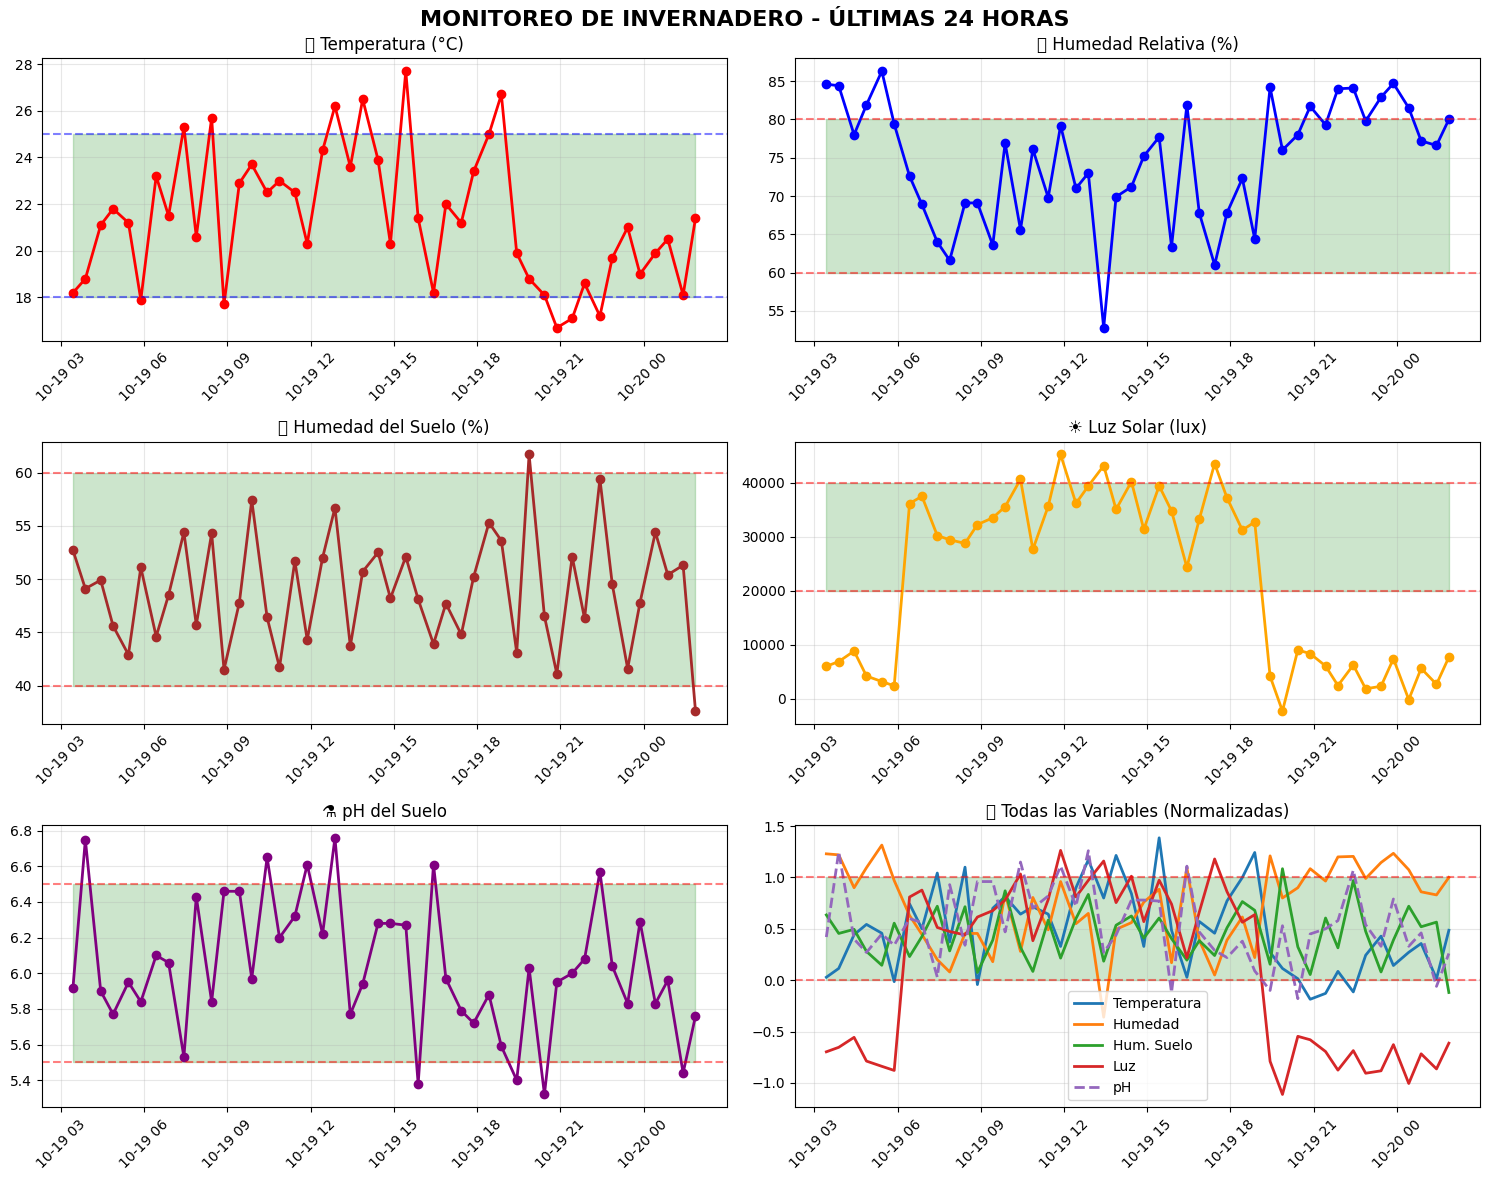


📰 NOTICIAS AGRÍCOLAS RELEVANTES

1. India necesita más cultivos y energía solar que ningún otro país. Así que está instalando los paneles solares en altura
   Fuente: Xataka.com
   Fecha: 2025-09-21T17:30:45Z
   URL: https://www.xataka.com/energia/india-necesita-cultivos-energia-solar-que-nadie-asi-que-ha-empezado-a-cosechar-dos-cosas-a-vez
------------------------------------------------------------
2. La NASA ha logrado hacer crecer lechugas en el espacio. Lo que ha descubierto después no era parte del plan
   Fuente: Xataka.com
   Fecha: 2025-10-06T12:01:01Z
   URL: https://www.xataka.com/espacio/nasa-ha-logrado-hacer-crecer-lechugas-espacio-que-ha-descubierto-despues-no-era-parte-plan
------------------------------------------------------------
3. Al arroz español le ha salido competencia en el país más inesperado de Europa: Inglaterra
   Fuente: Xataka.com
   Fecha: 2025-10-04T17:01:01Z
   URL: https://www.xataka.com/ecologia-y-naturaleza/al-arroz-espanol-le-ha-salido-rival-lugar

/tmp/ipython-input-2567051533.py:106: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2567051533.py:106: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2567051533.py:106: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2567051533.py:106: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2567051533.py:107: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.savefig('graficas_invernadero.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-2567051533.py:107: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  plt.savefig('graficas_invernadero.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-2567051533.py:107: UserWarning: Glyph 128166 (\N{SPLASHI

✓ Gráficas guardadas en 'graficas_invernadero.png'


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


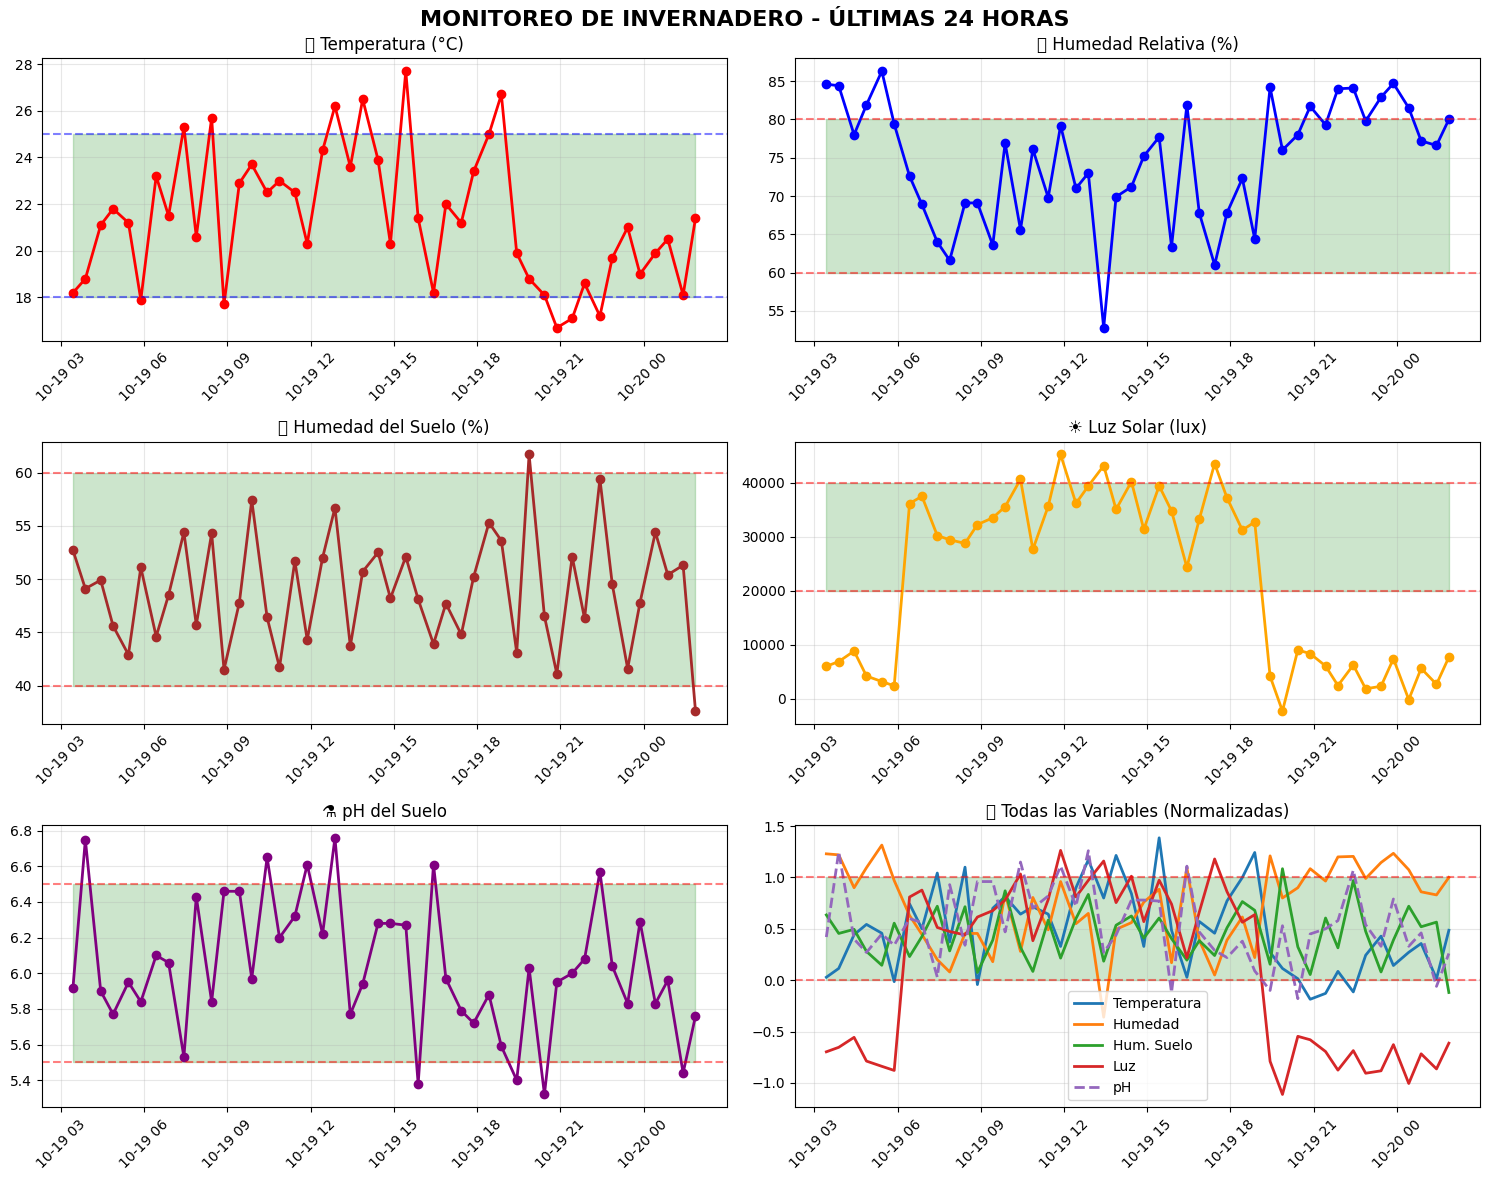


Presiona Enter para continuar...4

🌱 SISTEMA INTELIGENTE DE MONITOREO DE INVERNADEROS

Opciones:
1. Ver reporte actual (Español)
2. Ver reporte actual (English)
3. Generar gráficas
4. Ver estadísticas (7 días)
5. Verificar alertas
6. Ver noticias agrícolas
7. Exportar datos a CSV
8. Salir

Selecciona una opción (1-8): 5
[ADVERTENCIA] HUMEDAD_SUELO: 37.6% está por debajo del mínimo (40%)
[CRÍTICA] LUZ: 7738.0lux está por debajo del mínimo (20000lux)

Presiona Enter para continuar...6

🌱 SISTEMA INTELIGENTE DE MONITOREO DE INVERNADEROS

Opciones:
1. Ver reporte actual (Español)
2. Ver reporte actual (English)
3. Generar gráficas
4. Ver estadísticas (7 días)
5. Verificar alertas
6. Ver noticias agrícolas
7. Exportar datos a CSV
8. Salir

Selecciona una opción (1-8): 7
✓ Datos exportados a 'lecturas_invernadero.csv'
✓ Alertas exportadas a 'alertas_invernadero.csv'

Presiona Enter para continuar...8

🌱 SISTEMA INTELIGENTE DE MONITOREO DE INVERNADEROS

Opciones:
1. Ver reporte actual (Españ

/tmp/ipython-input-2567051533.py:106: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2567051533.py:106: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2567051533.py:106: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2567051533.py:106: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2567051533.py:107: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.savefig('graficas_invernadero.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-2567051533.py:107: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  plt.savefig('graficas_invernadero.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-2567051533.py:107: UserWarning: Glyph 128166 (\N{SPLASHI

✓ Gráficas guardadas en 'graficas_invernadero.png'


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


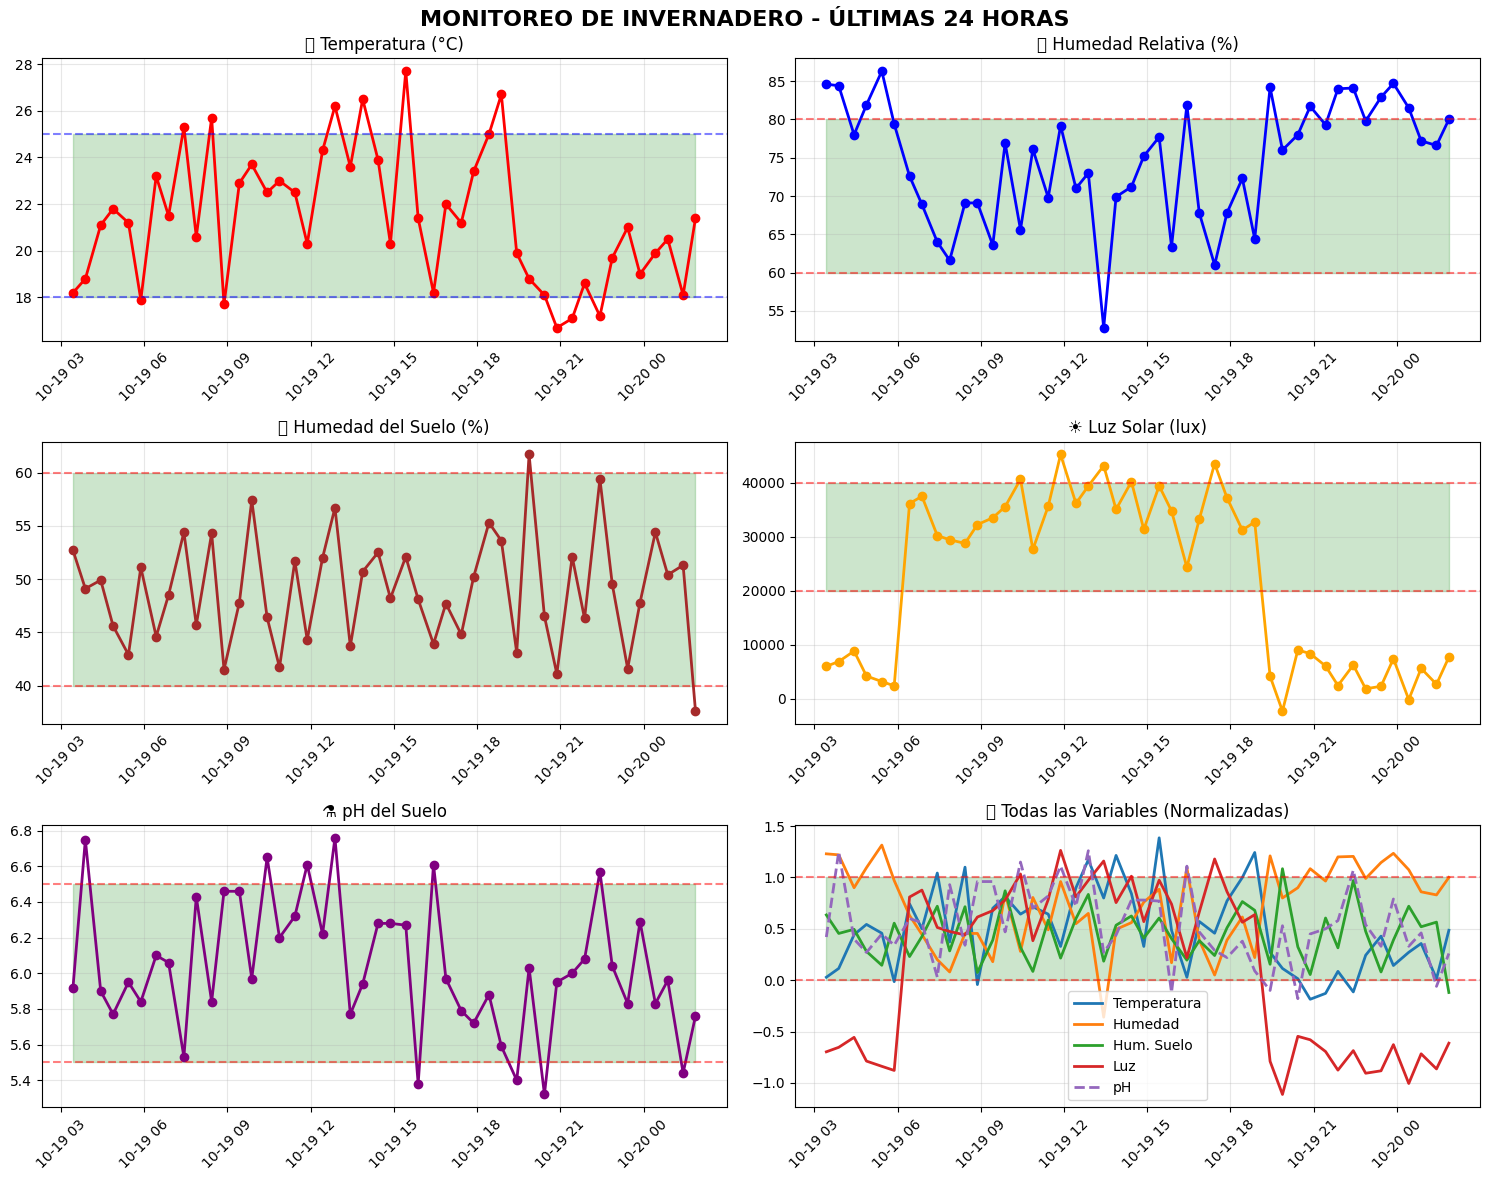


Presiona Enter para continuar...3

🌱 SISTEMA INTELIGENTE DE MONITOREO DE INVERNADEROS

Opciones:
1. Ver reporte actual (Español)
2. Ver reporte actual (English)
3. Generar gráficas
4. Ver estadísticas (7 días)
5. Verificar alertas
6. Ver noticias agrícolas
7. Exportar datos a CSV
8. Salir

Selecciona una opción (1-8): 4

📊 ESTADÍSTICAS DE LOS ÚLTIMOS 7 DÍAS

📈 Total de Lecturas: 336.0
⚠️  Lecturas Anormales: 179.0 (53.3%)

🌡️  TEMPERATURA:
   • Promedio: 21.2°C
   • Mínima: 14.4°C
   • Máxima: 28.1°C

💧 HUMEDAD RELATIVA:
   • Promedio: 74.5%

💦 HUMEDAD DEL SUELO:
   • Promedio: 49.7%

☀️  LUZ SOLAR:
   • Promedio: 21263 lux

⚗️  pH DEL SUELO:
   • Promedio: 6.01
   • Mínimo: 5.00
   • Máximo: 6.85

Presiona Enter para continuar...5

🌱 SISTEMA INTELIGENTE DE MONITOREO DE INVERNADEROS

Opciones:
1. Ver reporte actual (Español)
2. Ver reporte actual (English)
3. Generar gráficas
4. Ver estadísticas (7 días)
5. Verificar alertas
6. Ver noticias agrícolas
7. Exportar datos a CSV
8. Salir



In [48]:
# PARTE 15: EJECUCIÓN PRINCIPAL
# ============================================================
if __name__ == "__main__":
    print("🌱 Iniciando Sistema de Monitoreo de Invernaderos...")
    print("="*60)

    # 1. Inicializar base de datos
    print("\n[1/5] Inicializando base de datos...")
    inicializar_base_datos()

    # 2. Generar datos simulados
    print("\n[2/5] Generando datos simulados...")
    generar_datos_simulados(num_dias=7)

    # 3. Verificar alertas
    print("\n[3/5] Verificando alertas...")
    alertas = verificar_alertas()
    if alertas:
        print(f"\n⚠️  Se encontraron {len(alertas)} alertas:")
        for tipo, mensaje in alertas:
            print(f"   [{tipo}] {mensaje}")
    else:
        print("✓ No hay alertas activas")

    # 4. Generar reporte en español
    print("\n[4/5] Generando reporte en español...")
    reporte_es = generar_reporte_completo(idioma='es')
    print(reporte_es)

    # Guardar reporte en español
    with open('reporte_invernadero_ES.txt', 'w', encoding='utf-8') as f:
        f.write(reporte_es)
    print("✓ Reporte guardado en 'reporte_invernadero_ES.txt'")

    # 5. Generar reporte en inglés
    print("\n[5/5] Generando reporte en inglés...")
    reporte_en = generar_reporte_completo(idioma='en')
    print(reporte_en)

    # Guardar reporte en inglés
    with open('reporte_invernadero_EN.txt', 'w', encoding='utf-8') as f:
        f.write(reporte_en)
    print("✓ Reporte guardado en 'reporte_invernadero_EN.txt'")

    # Generar estadísticas
    print("\n")
    generar_estadisticas()

    # Generar gráficas
    print("\nGenerando gráficas...")
    generar_graficas()

    # Obtener noticias
    obtener_noticias_agricolas()

    # Exportar datos
    print("\nExportando datos...")
    exportar_datos_csv()

    print("\n" + "="*60)
    print("✅ SISTEMA INICIALIZADO CORRECTAMENTE")
    print("="*60)
    print("\nArchivos generados:")
    print("  • invernadero.db (Base de datos)")
    print("  • reporte_invernadero_ES.txt")
    print("  • reporte_invernadero_EN.txt")
    print("  • graficas_invernadero.png")
    print("  • lecturas_invernadero.csv")
    print("  • alertas_invernadero.csv")
    print("\n¡Proyecto completado exitosamente! 🎉")

    # Menú interactivo (opcional)
    while True:
        menu_principal()
        opcion = input("\nSelecciona una opción (1-8): ")

        if opcion == '1':
            print(generar_reporte_completo(idioma='es'))
        elif opcion == '2':
            print(generar_reporte_completo(idioma='en'))
        elif opcion == '3':
            generar_graficas()
        elif opcion == '4':
            generar_estadisticas()
        elif opcion == '5':
            alertas = verificar_alertas()
            if alertas:
                for tipo, mensaje in alertas:
                    print(f"[{tipo}] {mensaje}")
            else:
                print("✓ No hay alertas activas")
        elif opcion == '6':
            obtener_noticias_agricolas()
        elif opcion == '7':
            exportar_datos_csv()
        elif opcion == '8':
            print("\n👋 ¡Hasta pronto!")
            break
        else:
            print("⚠️ Opción inválida")

        input("\nPresiona Enter para continuar...")